# Hyperparameter Optimization

Import modules

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

import keras.backend as K

from scipy import stats

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as ax
from scipy.io import netcdf as nc

import csv

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

Read in input array

In [2]:
inputdata = np.load(file="../lhc_100.npy", allow_pickle=True)

Read in output data: training to predict global mean diff GPP, LHF

In [3]:
var = "GPP"
#var = "LHF"
f=nc.netcdf_file("../outputdata/outputdata_"+var+"_GM_100_diff.nc",'r', mmap=False) 
X = f.variables[var]
outputdata = X[:]

Separate training/test/val data: 60/20/20 split

In [4]:
x_train = inputdata[0:60]
x_test = inputdata[60:80]
x_val = inputdata[80:]
y_train = outputdata[0:60]
y_test = outputdata[60:80]
y_val = outputdata[80:]

Set # of nodes (2 hidden layers)

In [5]:
firstn = 5
secondn = 15

Define model metrics

In [6]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

### Define function for fitting a model and plotting learning curve

In [45]:
def fit_model(trainX, trainY, testX, testY, lrate):
    
    # define model
    model = Sequential()
    model.add(Dense(firstn, input_dim=inputdata.shape[1], activation='relu',
        kernel_regularizer=l2(.001)))
    model.add(Dense(secondn, activation='tanh', kernel_regularizer=l2(.001)))
    model.add(Dense(1))
    
    # compile model
    opt_dense = RMSprop(lr=lrate, rho=0.9, epsilon=None, decay=0.0)
    model.compile(opt_dense, "mse", metrics=[mean_sq_err])
    
    # fit model
    #results = model.fit(trainX, trainY, epochs=500, batch_size=30,
    #        verbose=0, validation_data=(testX,testY))
    # fit model w/ EarlyStopping
    es = EarlyStopping(monitor='val_loss', min_delta=1,
            patience=50, verbose=1, mode='min')
    results = model.fit(trainX, trainY, epochs=500, batch_size=30,
           callbacks=[es], verbose=0, validation_data=(testX,testY))
    maxep = max(results.epoch)
    
    # plot learning curves
    plt.plot(results.history['mean_sq_err'], label='train')
    plt.plot(results.history['val_mean_sq_err'], label='test')
    #plt.ylabel("Mean Squared Error") 
    plt.xlabel("Epochs", fontsize=10)
    plt.title('learning rate='+str(lrate), fontsize=12)
    
    # Make predictions
    #model_preds = model.predict(x_val)[:,0]
    #model_test = model.predict(x_test)[:,0]
    #model_train = model.predict(x_train)[:,0]
    
    # Calculate validation r^2
    #slope,intercept,r_value,p_value,std_err=stats.linregress(y_val,model_preds)
    #print("Prediction r-squared:", r_value**2)
    
    # scatterplot predicted vs. actual
    #plt.scatter(y_val, model_preds, label='validation')
    #plt.scatter(y_train, model_train, label='training')
    #plt.scatter(y_test, model_test, label= 'testing')
    #axbuff = 0.5
    #plt.xlim(np.amin(outputdata)-axbuff,np.amax(outputdata)+axbuff)
    #plt.ylim(np.amin(outputdata)-axbuff,np.amax(outputdata)+axbuff)                                                                           
    #plt.text(np.amin(outputdata),np.amin(outputdata), '$r^2$=%.2g' % r_value**2)
    #plt.title('lrate='+str(lrate))

Test different learning rates

In [43]:
#learning_rates = [1E-0, 1E-1, 1E-2, 1E-3, 1E-4, 1E-5, 1E-6, 1E-7]
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01, 0.001]
#learning_rates = [0.01, 0.008, 0.006, 0.005, 0.004, 0.002, 0.001]

Set up plots

### Loop over learning rates and plot

Epoch 00053: early stopping
Epoch 00093: early stopping
Epoch 00052: early stopping
Epoch 00061: early stopping
Epoch 00166: early stopping
Epoch 00188: early stopping
Epoch 00290: early stopping


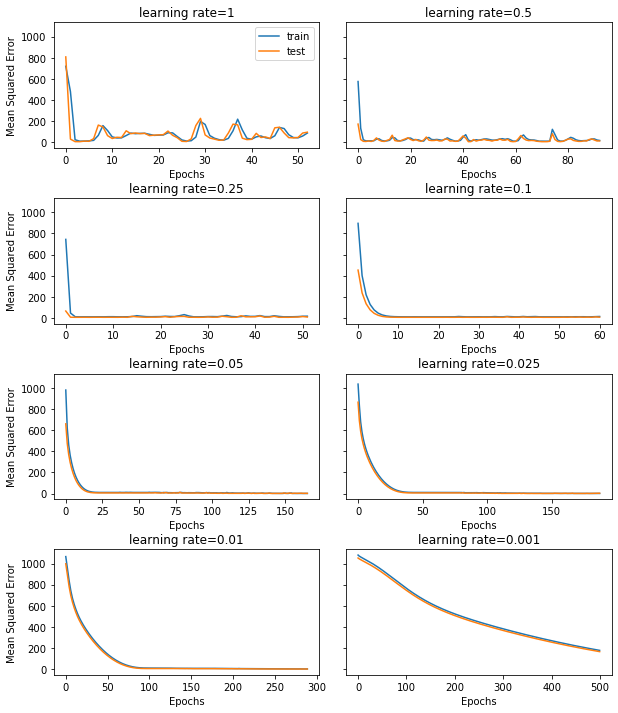

In [46]:
fig, axs = plt.subplots(4,2, figsize=(10, 12), sharey=True)
axs = axs.ravel()

for i in range(len(learning_rates)):
    
    # set random seed for reproducibility
    np.random.seed(9)
    
    # determine the plot number
    #plot_no = 420 + (i+1)
    plt.subplot(axs[i])
    
    # call function
    fit_model(x_train,y_train,x_test,y_test,learning_rates[i])

    # axis labels and legend
    if i%2 == 0:
        #plt.xlabel("Epochs")
        plt.ylabel("Mean Squared Error", fontsize=10)
        #plt.xlabel("CLM Model Output")
        #plt.ylabel("NN Predictions")
    if i ==0:
        plt.legend()
        
plt.subplots_adjust(wspace=0.1,hspace=0.4) 
#plt.savefig("tune_lr_v2_"+var+"_GM_diff.pdf")
#plt.savefig("tune_lr_es_"+var+"_GM_diff.pdf")